In [18]:
import os
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# SET PATH
path = f"{os.getcwd()}/dataset/train.parquet"
# LOAD PARQUET DATASET WITH FEATURE ENGINEERING
df = pd.read_parquet(path=path)

In [3]:
# REDUCE DTYPE FOR CUSTOMER AND DATE
df['customer_ID']= df['customer_ID'].str[-16:].apply(int, base=16)

# S_2 is not relevant so lets drop it
df.drop(['S_2'],axis=1,inplace=True)

# df = df.fillna(-127)

# There are multiple transactions. Let's take only the latest transaction from each customer.
df= df.groupby('customer_ID').tail(1)
df= df.set_index(['customer_ID'])

print('shape of data:', df.shape)

shape of data: (458913, 188)


In [4]:
df.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
13914591055249847850,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0
11750091188498716901,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,NaN,0.060646,...,-1,-1,-1,0,0,0.0,NaN,0,0.003169,0
7128959966677571777,0.880875,0,0.004284,0.812649,0.006450,NaN,0.0,0.007196,NaN,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.000834,0
6537921148391624412,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,NaN,0.046104,...,-1,-1,-1,0,0,0.0,NaN,0,0.005560,0
2065103583825424365,0.871900,0,0.007679,0.815746,0.001247,NaN,0.0,0.005528,NaN,0.044671,...,-1,-1,-1,0,0,0.0,NaN,0,0.006944,0


In [5]:
# Read and process Train Labels
targets = pd.read_csv(f"{os.getcwd()}/dataset/train_labels.csv")
targets['customer_ID'] = targets['customer_ID'].str[-16:].apply(int, base=16)
targets = targets.set_index('customer_ID')
train_data = df.merge(targets, left_index=True, right_index=True, how='left')
train_data.target = train_data.target.astype('int8')
del targets, df
# NEEDED TO MAKE CV DETERMINISTIC (Pandas merge above randomly shuffles rows)
train_data = train_data.sort_index().reset_index()

# FEATURES
FEATURES = train_data.columns[1:-1]
print(f'There are {len(FEATURES)} features!')
print("Train data Shape", train_data.shape)

There are 188 features!
Train data Shape (458913, 190)


In [6]:
x_train = train_data.drop(['target','customer_ID'],axis=1).values
y_train = train_data['target'].values

# PARAMS FOR RANDOMIZED-SEARCH-CV
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [9]:
# INITIALIZED XGBOOST MODEL
xgb_cal = xgb.XGBClassifier()

rs_model=RandomizedSearchCV(xgb_cal,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [17]:
# FITTING THE MODEL
enter_time = time.time()
rs_model.fit(x_train,y_train)
exit_time = time.time()

print("Total Time of Model Training in Minutes:", (exit_time-enter_time)*60)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3;, score=0.956 total time=22.0min
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5;, score=0.952 total time= 6.1min
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3;, score=0.958 total time= 6.0min
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3;, score=0.958 total time= 6.0min
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3;, score=0.957 total time= 6.0min
[CV 4/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=6, min_child_weight=1;, score=0.959 total time=21.1min
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=6, min_child_weight=5;, score=0.959 total time=15.0min
[CV 3/5] END colsample_bytr

In [18]:
rs_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [7]:
# Building final classifier model
xgb_cal = xgb.XGBClassifier(learning_rate=0.2, min_child_weight=1, max_depth=6, gamma=0.3, colsample_bytree=0.5)

kfold = 10
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)
lst_accu_stratified_test = []
lst_accu_stratified_train = []
for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train), start=1):
    print('[Fold %d/%d]' % (i, kfold))
    x_train_split, x_test_split  = x_train[train_index], x_train[test_index]
    y_train_split, y_test_split  = y_train[train_index], y_train[test_index]
    xgb_cal.fit(x_train_split, y_train_split)
    y_predict_test = xgb_cal.predict(x_test_split)
    lst_accu_stratified_test.append(accuracy_score(y_test_split, y_predict_test))
    y_predict_train = xgb_cal.predict(x_train_split)
    lst_accu_stratified_train.append(accuracy_score(y_train_split,y_predict_train))
    print('-> folds=%d, accuracy=%.3f' % (i, lst_accu_stratified_test[i-1]))


[Fold 1/10]
-> folds=1, accuracy=0.900
[Fold 2/10]
-> folds=2, accuracy=0.900
[Fold 3/10]
-> folds=3, accuracy=0.899
[Fold 4/10]
-> folds=4, accuracy=0.900
[Fold 5/10]
-> folds=5, accuracy=0.900
[Fold 6/10]
-> folds=6, accuracy=0.900
[Fold 7/10]
-> folds=7, accuracy=0.900
[Fold 8/10]
-> folds=8, accuracy=0.901
[Fold 9/10]
-> folds=9, accuracy=0.900
[Fold 10/10]
-> folds=10, accuracy=0.902


In [8]:
print(lst_accu_stratified_test)
print(lst_accu_stratified_train)

# Calculating Accuracy
print("Average Accuracy Score on test set:", np.mean(lst_accu_stratified_test))
print("Average Accuracy Score on train set:", np.mean(lst_accu_stratified_train))

[0.9003965832824893, 0.9001133095092827, 0.8991545367384294, 0.9003726220827614, 0.8998496437209911, 0.899675317600401, 0.9003290405526138, 0.9008738096794578, 0.9004815759081302, 0.9023120001743261]
[0.9119996319799719, 0.9119366811857024, 0.9122611198946301, 0.9123751277171676, 0.9122734382187874, 0.9121233251497499, 0.9113485480192338, 0.9119756332592452, 0.9117916236907477, 0.91153982112333]
Average Accuracy Score on test set: 0.9003558439248884
Average Accuracy Score on train set: 0.9119624950238567


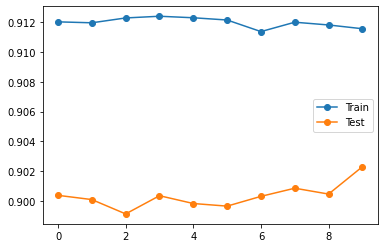

In [9]:
# plot of train and test scores
values = [i for i in range(kfold)]
plt.plot(values, lst_accu_stratified_train, '-o', label='Train')
plt.plot(values, lst_accu_stratified_test, '-o', label='Test')
plt.legend()
plt.show()

In [10]:
# SET TEST DATA PATH
path = f"{os.getcwd()}/dataset/test.parquet"
# LOAD PARQUET DATASET WITH FEATURE ENGINEERING
df_test = pd.read_parquet(path=path)

In [13]:
# S_2 is not relevant so lets drop it
df_test.drop(['S_2'],axis=1,inplace=True)

# There are multiple transactions. Let's take only the latest transaction from each customer.
df_test= df_test.groupby('customer_ID').tail(1)
df_test= df_test.set_index(['customer_ID'])

df_test.shape

(924621, 188)

In [14]:
y_test_predict=xgb_cal.predict_proba(df_test)

In [15]:
y_predict_final=y_test_predict[:,1]
submission = pd.DataFrame({"customer_ID":df_test.index,"prediction":y_predict_final})

In [16]:
submission.to_csv('amex-submission.csv', index=False)

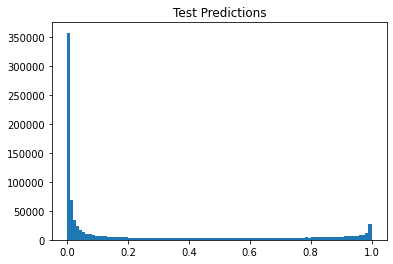

In [27]:
# PLOT PREDICTIONS
plt.hist(submission.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

In [32]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])

    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four)

amex_metric_score_test = amex_metric_mod(y_test_split, y_predict_test)
print("Amex Metric Score on test data: ", amex_metric_score_test)


Amex Metric Score on test data:  0.5845645208501955
